In [44]:
import numpy as np
import matplotlib.pyplot as plt
import uncertainties as unc
import uncertainties.unumpy as unp
#from matplotlib import colors
from scipy.optimize import curve_fit
from scipy.stats import chi2

%matplotlib inline

## Auswertung Teil 1
### Zeitliche Verläufe

In [45]:
# Einlesen der gemessenen Werte
num1, t1, co2, tempAir, wind, waterHeight, p0 = np.loadtxt('teil1/FP_21_11_2016_13_43_13-data.asc', 
                                                           unpack=True, skiprows=1)

num2, t2, conduct, tempWater = np.loadtxt('teil1/FP_21_11_2016_13_43_44_Conductivity_Twater-data.asc', 
                                         unpack=True, skiprows=1)

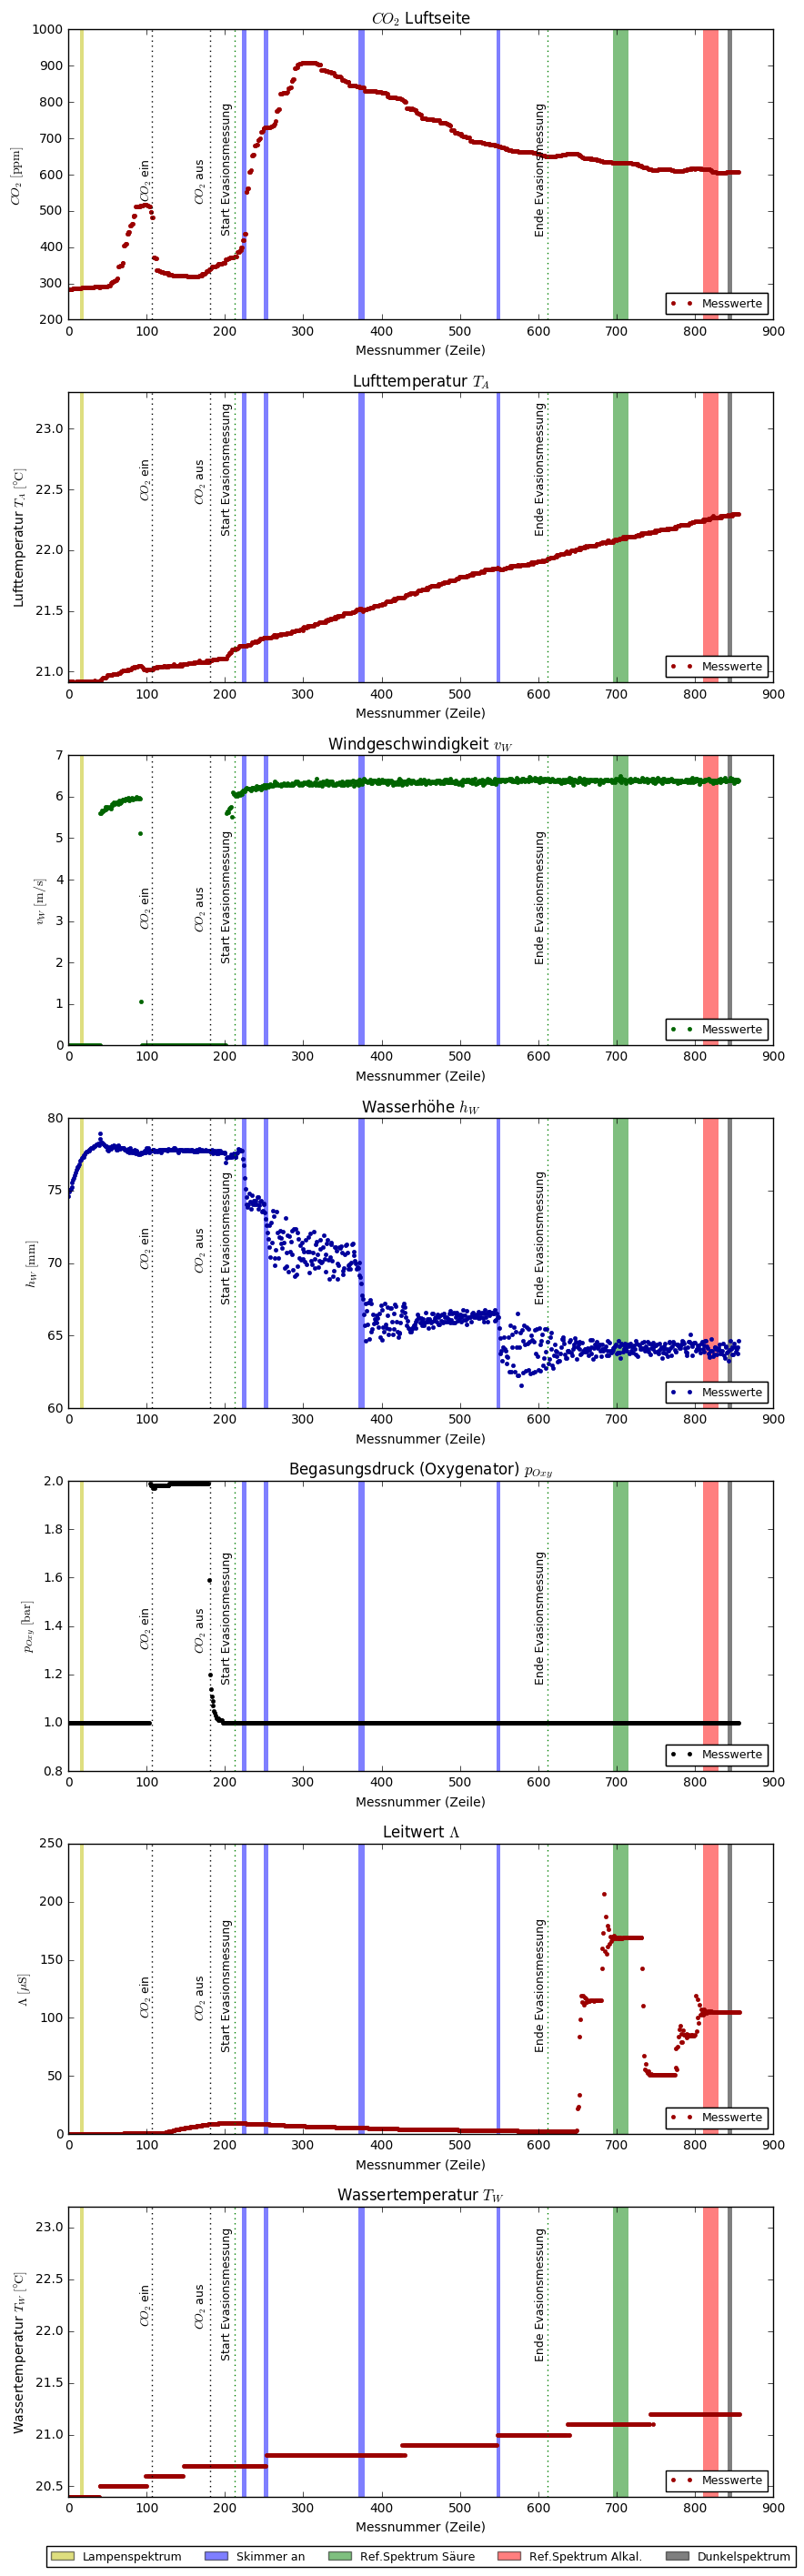

In [46]:
# general setup
#fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2)
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7)
fig.set_figheight(35)
fig.set_figwidth(10)
fig.subplots_adjust(hspace=0.25)

### ax specific cosmetics
ax1.plot(num1, co2, '#9B0000', marker='.', linestyle='none', label='Messwerte')
ax1.set_title('$CO_2$ Luftseite')
ax1.set_ylabel('$CO_2\ [\\mathrm{ppm}]$ ')

ax2.plot(num1, tempAir, '#9B0000', marker='.', linestyle='none', label='Messwerte')
ax2.set_ylim(tempAir.min(), tempAir.max()+1)
ax2.set_title('Lufttemperatur $T_{A}$')
ax2.set_ylabel('Lufttemperatur $T_{A}\ [\\mathrm{\\degree C}]$')

ax3.plot(num1, wind, '#006400', marker='.', linestyle='none',label='Messwerte' )
ax3.set_title('Windgeschwindigkeit $v_W$')
ax3.set_ylabel('$v_W\ [\\mathrm{m/s}]$')

ax4.plot(num1, waterHeight, '#00009B', marker='.', linestyle='none', label='Messwerte')
ax4.set_title('Wasserhöhe $h_W$')
ax4.set_ylabel('$h_W\ [\\mathrm{mm}]$')

ax5.plot(num1, p0, 'k.', label='Messwerte')
ax5.set_title('Begasungsdruck (Oxygenator) $p_{Oxy}$')
ax5.set_ylabel('$p_{Oxy}\ [\\mathrm{bar}]$')

ax6.plot(num2[1:]-1, conduct[1:], '#9B0000', marker='.', linestyle='none', label='Messwerte')
ax6.set_title('Leitwert $\\Lambda$')
ax6.set_ylabel('$\\Lambda\ [\\mathrm{\\mu S}] $')

ax7.plot(num2[1:]-1, tempWater[1:], '#9B0000', marker='.', linestyle='none', label='Messwerte')
ax7.set_title('Wassertemperatur $T_{W}$')
ax7.set_ylabel('Wassertemperatur $T_W\ [\\mathrm{\\degree C}]$')
ax7.set_ylim(tempWater.min(), tempWater.max()+2)

### cosmetics for all plots:
for i in [ax1, ax2, ax3, ax4, ax5, ax6, ax7]:
    i.set_xlabel('Messnummer (Zeile)')
    yBounds = i.get_ybound()  # get the boundaries of y axis
    yHeight = (yBounds[1]+yBounds[0])/1.95
    
    #span parameters for skimmer
    ec = 'none'
    fc = 'b'
    op = 0.5
    
    # led spectrum (on)
    i.axvspan(15, 20, edgecolor=ec, facecolor='y', alpha=op, label='Lampenspektrum')

    # co2 lines, exp. start
    i.axvline(x=107, ls='dotted', color='k')  # CO2 on
    i.text(90, yHeight, '$CO_2$ ein', rotation=90, fontsize=9)
    i.axvline(x=181, ls='dotted', color='k')  # CO2 off
    i.text(160, yHeight, '$CO_2$ aus', rotation=90, fontsize=9)
    i.axvline(x=212, ls='dotted', color='g')  # start exp.
    i.text(195, yHeight, 'Start Evasionsmessung', rotation=90, fontsize=9, va='center')
    
    # skimmer spans
    i.axvspan(222, 228, edgecolor=ec, facecolor=fc, alpha=op, label='Skimmer an')  # skimmer
    i.axvspan(249, 255, edgecolor=ec, facecolor=fc, alpha=op)  # skimmer
    i.axvspan(370, 378, edgecolor=ec, facecolor=fc, alpha=op)  # skimmer
    i.axvspan(547, 552, edgecolor=ec, facecolor=fc, alpha=op)  # skimmer
    
    # exp. end
    i.axvline(x=612, ls='dotted', color='g') 
    i.text(595, yHeight, 'Ende Evasionsmessung', rotation=90, fontsize=9, va='center')
    
    # spectrum measurements
    i.axvspan(695, 715, edgecolor=ec, facecolor='g', alpha=op, label='Ref.Spektrum Säure')  # Ref. Spec. acid
    i.axvspan(810, 830, edgecolor=ec, facecolor='r', alpha=op, label='Ref.Spektrum Alkal.')  # Ref. Spec. acid

    # led spectrum off
    i.axvspan(842, 847, edgecolor=ec, facecolor='k', alpha=op, label='Dunkelspektrum')
    
    # legend handling
    handles, labels = i.get_legend_handles_labels()  # getting the handles and the labels of the legend
    first_legend = i.legend(handles[:1], labels[:1], loc=4, fontsize=9)  # we just want the first entry of each legend
    i.add_artist(first_legend)  # add the legend as artist because we need a 2nd one later
    
plt.legend(handles[1:], labels[1:], bbox_to_anchor=(1.04, -0.15), ncol=5, fontsize=9)  # 2nd legend, with the rest of the handles and labels
#fig.savefig('zeitverlaeufe_teil1.pdf', dpi=200)

### Anfangskonzentration von $CO_2$

In [47]:
# aus pV = nRT => n = 50.924 mol
# brauchen noch Wasservolumen -> Mittelwert über Wasserstandshöhe:
hW_mean = np.mean(waterHeight[117:181])
hW_mean_err = np.std(waterHeight[117:181])/np.sqrt(181-117)
hW = unc.ufloat(hW_mean, hW_mean_err)

# effektive wassersäule
hW = (hW + unc.ufloat(6.89, 0.04))*1e-3  ## [m]
print('effektive Wassersäule ist:', hW, '[m]')

effektive Wassersäule ist: 0.08467+/-0.00004 [m]


In [48]:
VW = hW*157079.63*1e-6  # [m^3]
c = 0.0506/VW 
print('Konzentration zu Beginn:', c ,'[mol/m^3] = ', c*1e3, '[mol/l]')
c = c * 1e3  # [mol/l]

Konzentration zu Beginn: 3.8043+/-0.0018 [mol/m^3] =  3804.3+/-1.8 [mol/l]


### Plots von $c_W/ \alpha$ und $c_A$ über Zeit

In [49]:
# Löslichkeit ist quasi konstant für unseren T Bereich (21C < T < 23C)
alpha = unc.ufloat(0.037445, 0.000535)  # Mittelwert aus den alpha-werten für 21 u 22 C. [mol/l]

# da co2 in Luft offset hat:
co2_off = unc.ufloat(170,30)
cA = co2-co2_off  # [cA] = ppm

# lamba^2 ist prop. zu c_W. da wir c0=c wissen (siehe oben), wissen wir: lambda_0**2 / lambda(t)**2 = c/c(t)
cW = c * conduct**2 / conduct[211]**2 / alpha

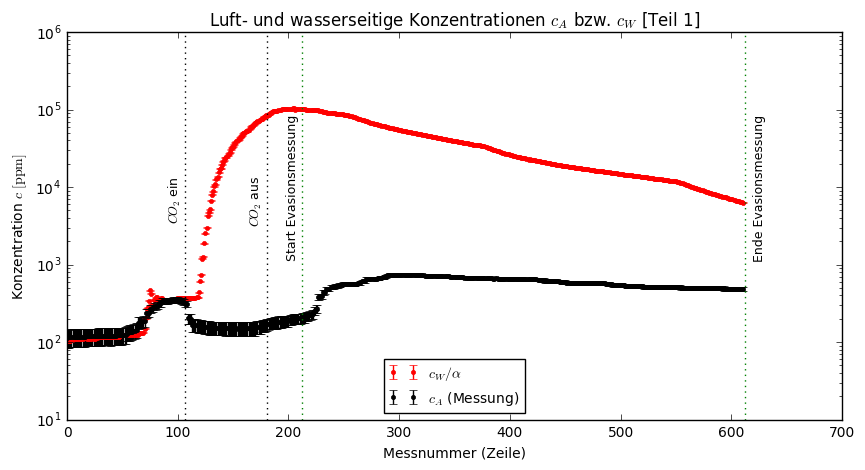

In [50]:
#plotting section

upper_lim = 612  # just convenience

plt.figure(figsize=(10,5))
plt.errorbar((num2[1:upper_lim+1]-1), unp.nominal_values(cW)[1:upper_lim+1], 
             yerr=unp.std_devs(cW)[1:upper_lim+1], fmt='r.', 
             label='$c_W/\\alpha$')  # graph 1
plt.errorbar(num1[:upper_lim], unp.nominal_values(cA)[:upper_lim], 
             yerr=unp.std_devs(cA)[:upper_lim], fmt='k.', 
             label='$c_A$ (Messung)')  # graph 2
plt.yscale('log')

plt.title('Luft- und wasserseitige Konzentrationen $c_A$ bzw. $c_W$ [Teil 1]')
plt.xlabel('Messnummer (Zeile)')
plt.ylabel('Konzentration $c\ [\\mathrm{ppm}]$')

# co2 lines, exp. start
yHeight = 1e4
plt.axvline(x=107, ls='dotted', color='k')  # CO2 on
plt.text(90, yHeight, '$CO_2$ ein', rotation=90, fontsize=9)
plt.axvline(x=181, ls='dotted', color='k')  # CO2 off
plt.text(163, yHeight, '$CO_2$ aus', rotation=90, fontsize=9)
plt.axvline(x=212, ls='dotted', color='g')  # start exp.
plt.text(198, yHeight, 'Start Evasionsmessung', rotation=90, fontsize=9, va='center')

# exp. end
plt.axvline(x=612, ls='dotted', color='g') 
plt.text(620, yHeight, 'Ende Evasionsmessung', rotation=90, fontsize=9, va='center')
plt.legend(loc=8, fontsize=10)
#plt.savefig('luft_wasser_konzentrationen.pdf', dpi=200)

### Fitten des Konzentrationsverlaufs mit Exponentialfunktionen

Fit 1 -  [  2.38255706e-05   1.63910508e+05] [  1.84898543e-06   6.27725120e+03]
<hW>: 77.636 0.202049498886 
<vW>: 6.05 0.0282842712475 
<tempWater>: 20.7 3.5527136788e-15
Fit 2 -  [  5.31844176e-05   3.06442508e+05] [  2.27305225e-06   1.58638346e+04]
<hW>: 74.130952381 0.329630453429 
<vW>: 6.20619047619 0.0266326313412 
<tempWater>: 20.7 3.5527136788e-15
Fit 3 -  [  7.72009182e-05   5.17614945e+05] [  7.46318027e-07   1.15925246e+04]
<hW>: 70.8006956522 1.0304931042 
<vW>: 6.31565217391 0.0349192966407 
<tempWater>: 20.8 7.1054273576e-15
Fit 4 -  [  5.80430599e-05   2.37803862e+05] [  6.73404242e-07   7.11505789e+03]
<hW>: 66.1562130178 0.530810345851 
<vW>: 6.35982248521 0.0323712446869 
<tempWater>: 20.8698224852 0.0459028221378


/usr/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in exp


'\n#####################\ndef linreg(x,k,d):\n    return k/unp.nominal_values(hW)*x+d\n\nprint("\n test 2:")\nparams2 = []\nplt.figure(figsize=(10,5))\nplt.plot((num2[1:upper_lim+1]-1), unp.nominal_values(unp.log(cW))[1:upper_lim+1], \n             #yerr=unp.std_devs(cW)[1:upper_lim+1], fmt=\'r.\', \n             \'r.\',\n             label=\'$c_W/\\alpha$\')  # graph 1\n\nfor num,(l,u) in enumerate(zip(llims[:-1],ulims[:-1])):\n    #l-=1\n    #u-=1\n    num+=1\n\n    popt2, pcov2 = curve_fit(linreg, t2[l:u], unp.nominal_values(unp.log(cW[l:u])), \n                           sigma=unp.std_devs(unp.log(cW[l:u])),\n                           p0=[2e-5, 1e1])\n    \n    popt_err2 = np.sqrt(np.diag(pcov2))\n    params2.append(unp.uarray(popt2, popt_err2))\n    #params_err.append(popt_err)\n    print(\'Fit\', num, \'- \', popt2, popt_err2)\n\n    plt.plot(num2[l:u], linreg(t2[l:u], *popt2), \'k-\', label=\'fit\')\n\nplt.legend()\n'

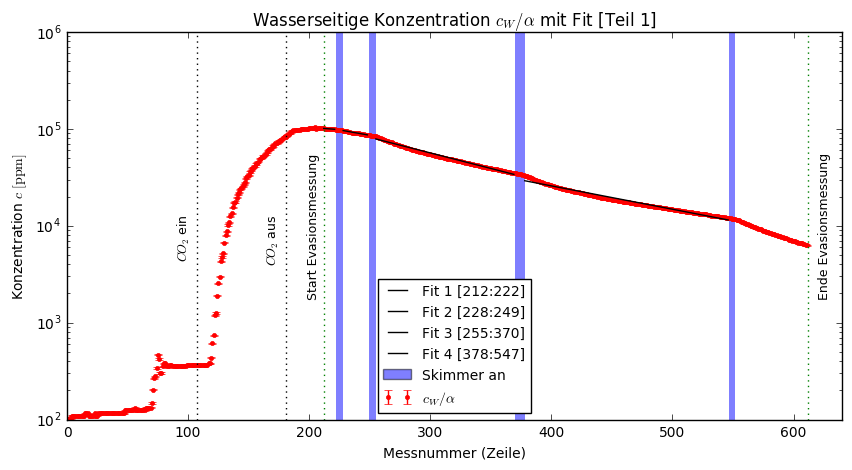

In [51]:
#l = 212-1
#u = 220-1
def exp(t, k, A):
    return A*np.exp(-k/unp.nominal_values(hW) * t)

# list of lower and upper limits:
llims = [212, 228, 255, 378]
ulims = [222, 249, 370, 547]

params = []
params_err = []

plt.figure(figsize=(10,5))
plt.errorbar((num2[1:upper_lim+1]-1), unp.nominal_values(cW)[1:upper_lim+1], 
             yerr=unp.std_devs(cW)[1:upper_lim+1], fmt='r.', 
             label='$c_W/\\alpha$')  # graph 1
plt.yscale('log')

for num,(l,u) in enumerate(zip(llims,ulims)):
    #l-=1
    #u-=1
    num+=1

    popt, pcov = curve_fit(exp, t2[l:u], unp.nominal_values(cW[l:u]) ,sigma=unp.std_devs(cW[l:u]),
                      p0=[0.0002, unp.nominal_values(c/alpha)])
    popt_err = np.sqrt(np.diag(pcov))
    params.append(unp.uarray(popt, popt_err))
    #params_err.append(popt_err)
    print('Fit', num, '- ', popt, popt_err)

    plt.plot(num2[l:u], exp(t2[l:u], *popt), 'k-', 
             label='Fit '+str(num) + ' [' + str(l) + ':'+ str(u) + ']')
    print("<hW>:", np.mean(waterHeight[l:u]), np.std(waterHeight[l:u]), 
          "\n<vW>:", np.mean(wind[l:u]), np.std(wind[l:u]),
          "\n<tempWater>:", np.mean(tempWater[l:u]), np.std(tempWater[l:u]))

    
plt.title('Wasserseitige Konzentration $c_W/\\alpha$ mit Fit [Teil 1]')
plt.xlabel('Messnummer (Zeile)')
plt.ylabel('Konzentration $c\ [\\mathrm{ppm}]$')
plt.xlim(0,640)

#span parameters for skimmer
ec = 'none'
fc = 'b'
op = 0.5
    
# skimmer spans
plt.axvspan(222, 228, edgecolor=ec, facecolor=fc, alpha=op, label='Skimmer an')  # skimmer
plt.axvspan(249, 255, edgecolor=ec, facecolor=fc, alpha=op)  # skimmer
plt.axvspan(370, 378, edgecolor=ec, facecolor=fc, alpha=op)  # skimmer
plt.axvspan(547, 552, edgecolor=ec, facecolor=fc, alpha=op)  # skimmer


# co2 lines, exp. start
yHeight = 1e4
plt.axvline(x=107, ls='dotted', color='k')  # CO2 on
plt.text(90, yHeight, '$CO_2$ ein', rotation=90, fontsize=9)
plt.axvline(x=181, ls='dotted', color='k')  # CO2 off
plt.text(163, yHeight, '$CO_2$ aus', rotation=90, fontsize=9)
plt.axvline(x=212, ls='dotted', color='g')  # start exp.
plt.text(198, yHeight, 'Start Evasionsmessung', rotation=90, fontsize=9, va='center')

# exp. end
plt.axvline(x=612, ls='dotted', color='g') 
plt.text(620, yHeight, 'Ende Evasionsmessung', rotation=90, fontsize=9, va='center')
plt.legend(loc=8, fontsize=10)
#plt.savefig('wasserkonzentration_fit.pdf', dpi=200)
"""
#####################
def linreg(x,k,d):
    return k/unp.nominal_values(hW)*x+d

print("\n test 2:")
params2 = []
plt.figure(figsize=(10,5))
plt.plot((num2[1:upper_lim+1]-1), unp.nominal_values(unp.log(cW))[1:upper_lim+1], 
             #yerr=unp.std_devs(cW)[1:upper_lim+1], fmt='r.', 
             'r.',
             label='$c_W/\\alpha$')  # graph 1

for num,(l,u) in enumerate(zip(llims[:-1],ulims[:-1])):
    #l-=1
    #u-=1
    num+=1

    popt2, pcov2 = curve_fit(linreg, t2[l:u], unp.nominal_values(unp.log(cW[l:u])), 
                           sigma=unp.std_devs(unp.log(cW[l:u])),
                           p0=[2e-5, 1e1])
    
    popt_err2 = np.sqrt(np.diag(pcov2))
    params2.append(unp.uarray(popt2, popt_err2))
    #params_err.append(popt_err)
    print('Fit', num, '- ', popt2, popt_err2)

    plt.plot(num2[l:u], linreg(t2[l:u], *popt2), 'k-', label='fit')

plt.legend()
"""

In [52]:
params = np.array(params)
#params2 = np.array(params2)
print('Transfergeschwindigkeit k:','\nexp-fit:', np.mean(params[:,0]),'[m\s] = ', np.mean(params[:,0])*3.6e5, 
      '[cm/h]\n')#lin-fit:', -1*np.mean(params2[:,0]), '[m\s] = ', np.mean(params[:,0])*3.6e5, '[cm/h]')


Transfergeschwindigkeit k: 
exp-fit: (5.31+/-0.08)e-05 [m\s] =  19.10+/-0.28 [cm/h]



## $\frac{HI}{I^-}$ Verlauf

In [53]:
num, time, HIoverI = np.genfromtxt('Auswertung_heurisko/FP_21_11_2016_13_43_13_HIoverI_Wavebin0300to0340.txt',
                                  skip_header=1, max_rows=843, unpack=True)

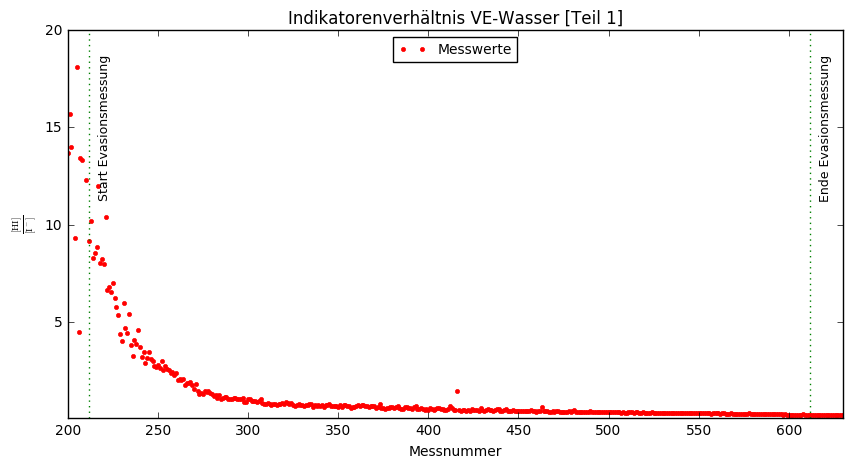

In [54]:
plt.figure(figsize=(10,5))
plt.plot(num, HIoverI, 'r.', label='Messwerte')
#plt.plot(num[indices], HI_I_masked, 'k.')
plt.xlim(200, 630)
plt.ylim(0.1, 20)
plt.ylabel('$\\frac{[\\mathrm{HI}]}{[\\mathrm{I^-}]}$')
plt.xlabel('Messnummer')
plt.title('Indikatorenverhältnis VE-Wasser [Teil 1]')
plt.legend(loc=9, fontsize=10)

# co2 lines, exp. start
yHeight = 15
plt.axvline(x=212, ls='dotted', color='g')  # start exp.
plt.text(217, yHeight, 'Start Evasionsmessung', rotation=90, fontsize=9, va='center')
# exp. end
plt.axvline(x=612, ls='dotted', color='g') 
plt.text(617, yHeight, 'Ende Evasionsmessung', rotation=90, fontsize=9, va='center')
#plt.savefig('Indikatorverhaeltnis_vewasser.pdf', dpi=200)

In [55]:
# Indikatorenverhältins zu beginn der Messung:
HIoverI_0 = HIoverI[211]  # proportional zu c
cW_ind = c * HIoverI / HIoverI_0 / alpha

Fit 1 [  2.83620140e-04   9.39557748e+06] [  6.08067933e-06   1.41455901e+06]
<hW>: 73.1455681818 2.41132359822 
<vW>: 6.23545454545 0.0874111118757 
<tempWater>: 20.7522727273 0.0499483203996
<k> 0.000283620139879


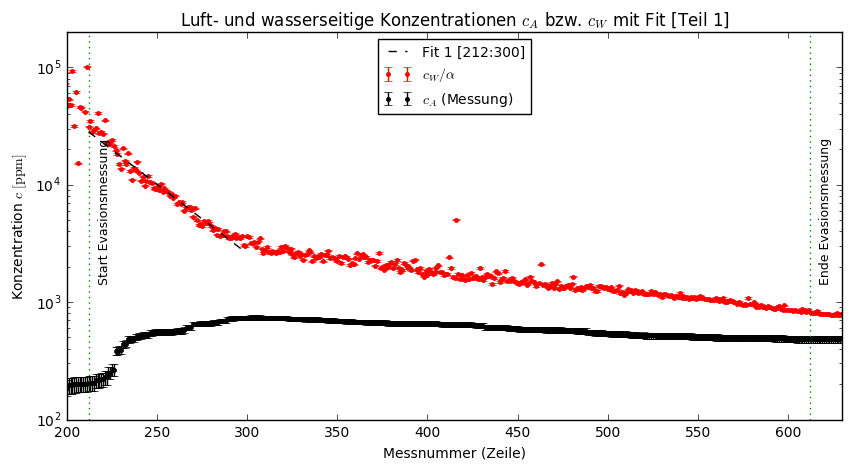

In [56]:
def exp_off(t, k, A, offset):
    return A*np.exp(-k/unp.nominal_values(hW) * t) - offset

plt.figure(figsize=(10,5))
pars = []
par_errs = []

lower = [212]
upper = [300]

plt.errorbar(num, unp.nominal_values(cW_ind), yerr=unp.std_devs(cW_ind), fmt='r.', label='$c_W/\\alpha$')
plt.errorbar(num[200:630], unp.nominal_values(cA)[200:630], 
             yerr=unp.std_devs(cA)[200:630], 
             fmt='k.', label='$c_A$ (Messung)')  # graph 2

for enum,(l,u) in enumerate(zip(lower,upper)):
    enum +=1
    popt, pcov = curve_fit(exp, time[l:u], unp.nominal_values(cW_ind[l:u]) ,sigma=unp.std_devs(cW_ind[l:u]),
                          p0=[1e-4, unp.nominal_values(c/alpha)p0p0p0])#, 1])
    popt_err = np.sqrt(np.diag(pcov))
    print('Fit '+str(enum), popt, popt_err)
    plt.plot(num[l:u], exp(time[l:u], *popt), 'k--', label='Fit ' + str(enum) + ' [' + str(l) + ':'+ str(u) + ']')
    
    pars.append(popt)
    par_errs.append(popt_err)
    
    print("<hW>:", np.mean(waterHeight[l:u]), np.std(waterHeight[l:u]), 
          "\n<vW>:", np.mean(wind[l:u]), np.std(wind[l:u]),
          "\n<tempWater>:", np.mean(tempWater[l:u]), np.std(tempWater[l:u]))
    

# co2 lines, exp. start
yHeight = 6e3
plt.axvline(x=212, ls='dotted', color='g')  # start exp.
plt.text(217, yHeight, 'Start Evasionsmessung', rotation=90, fontsize=9, va='center')
# exp. end
plt.axvline(x=612, ls='dotted', color='g') 
plt.text(617, yHeight, 'Ende Evasionsmessung', rotation=90, fontsize=9, va='center')

plt.title('Luft- und wasserseitige Konzentrationen $c_A$ bzw. $c_W$ mit Fit [Teil 1]')
plt.xlabel('Messnummer (Zeile)')
plt.ylabel('Konzentration $c\ [\\mathrm{ppm}]$')
#plt.plot(num[l:u], exp(time[l:u], *popt), 'k--', label='Fit')
plt.xlim(200, 630)
plt.ylim(100,2e5 )
plt.yscale('log')
plt.legend(loc=0, fontsize=10)
pars = np.array(pars)
#plt.savefig('konzentration_luft_wasser_teil1_fit.pdf', dpi=200)

print('<k>', np.mean(pars[:,0]))

## Auswertung Teil 2

In [57]:
# Einlesen der gemessenen Werte 
num1, t1, co2, tempAir, wind, waterHeight, p0 = np.loadtxt('teil2/FP_21_11_2016_16_05_35-data.asc', 
                                                           unpack=True, skiprows=1)

num2, t2, conduct, tempWater = np.loadtxt('teil2/FP_21_11_2016_16_05_54_Conductivity_Twater-data.asc', 
                                         unpack=True, skiprows=1)

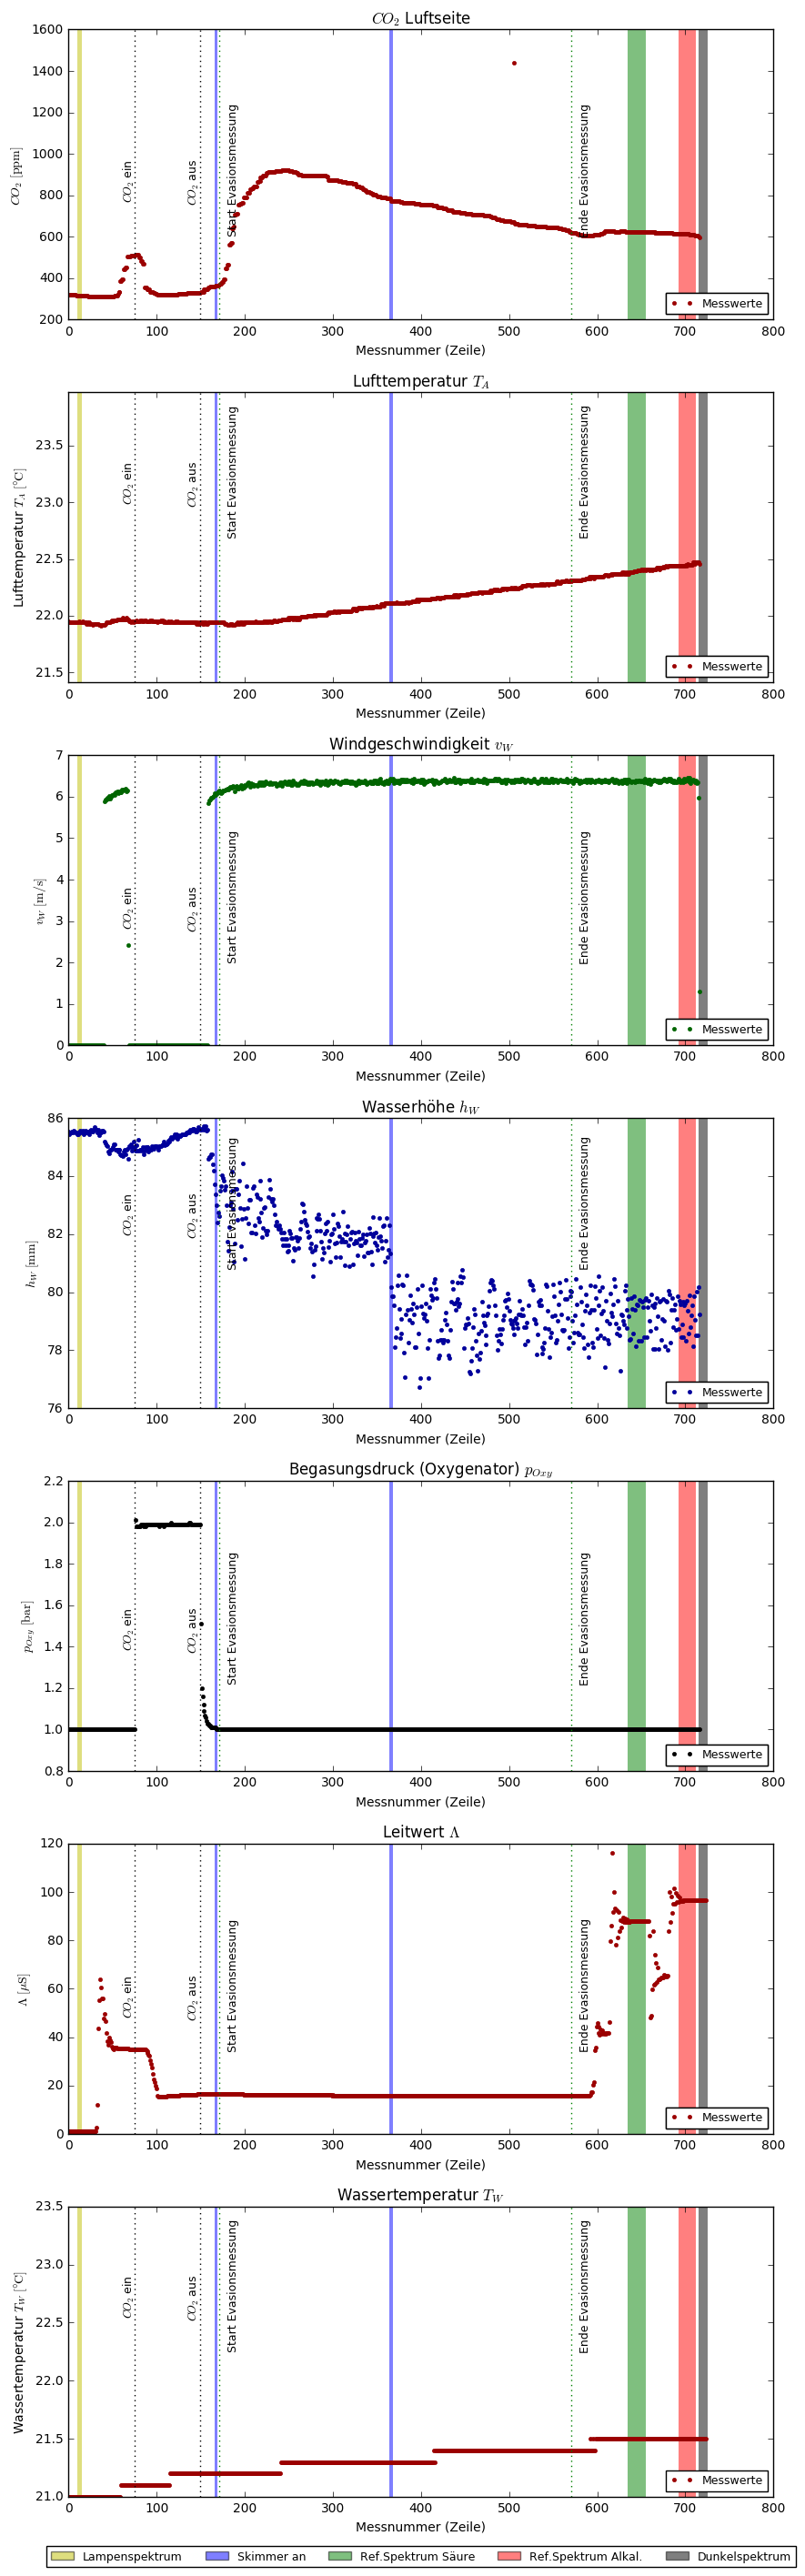

In [58]:
# general setup
#fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2)
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7)
fig.set_figheight(35)
fig.set_figwidth(10)
fig.subplots_adjust(hspace=0.25)

### ax specific cosmetics
ax1.plot(num1, co2, '#9B0000', marker='.', linestyle='none', label='Messwerte')
ax1.set_title('$CO_2$ Luftseite')
ax1.set_ylabel('$CO_2\ [\\mathrm{ppm}]$ ')

ax2.plot(num1, tempAir, '#9B0000', marker='.', linestyle='none', label='Messwerte')
ax2.set_ylim(tempAir.min(), tempAir.max()+1)
ax2.set_title('Lufttemperatur $T_{A}$')
ax2.set_ylabel('Lufttemperatur $T_{A}\ [\\mathrm{\\degree C}]$')
ax2.set_ylim(tempAir.min()-0.5, tempAir.max()+1.5)

ax3.plot(num1, wind, '#006400', marker='.', linestyle='none',label='Messwerte' )
ax3.set_title('Windgeschwindigkeit $v_W$')
ax3.set_ylabel('$v_W\ [\\mathrm{m/s}]$')

ax4.plot(num1, waterHeight, '#00009B', marker='.', linestyle='none', label='Messwerte')
ax4.set_title('Wasserhöhe $h_W$')
ax4.set_ylabel('$h_W\ [\\mathrm{mm}]$')

ax5.plot(num1, p0, 'k.', label='Messwerte')
ax5.set_title('Begasungsdruck (Oxygenator) $p_{Oxy}$')
ax5.set_ylabel('$p_{Oxy}\ [\\mathrm{bar}]$')

ax6.plot(num2[1:]-1, conduct[1:], '#9B0000', marker='.', linestyle='none', label='Messwerte')
ax6.set_title('Leitwert $\\Lambda$')
ax6.set_ylabel('$\\Lambda\ [\\mathrm{\\mu S}] $')

ax7.plot(num2[1:]-1, tempWater[1:], '#9B0000', marker='.', linestyle='none', label='Messwerte')
ax7.set_title('Wassertemperatur $T_{W}$')
ax7.set_ylabel('Wassertemperatur $T_W\ [\\mathrm{\\degree C}]$')
ax7.set_ylim(tempWater.min(), tempWater.max()+2)

### cosmetics for all plots:
for i in [ax1, ax2, ax3, ax4, ax5, ax6, ax7]:
    i.set_xlabel('Messnummer (Zeile)')
    yBounds = i.get_ybound()  # get the boundaries of y axis
    yHeight = (yBounds[1]+yBounds[0])/1.95
    
    #span parameters for skimmer
    ec = 'none'
    fc = 'b'
    op = 0.5
    
    # led spectrum (on)
    i.axvspan(10, 15, edgecolor=ec, facecolor='y', alpha=op, label='Lampenspektrum')

    # co2 lines, exp. start
    i.axvline(x=75, ls='dotted', color='k')  # CO2 on
    i.text(60, yHeight, '$CO_2$ ein', rotation=90, fontsize=9)
    i.axvline(x=149, ls='dotted', color='k')  # CO2 off
    i.text(134, yHeight, '$CO_2$ aus', rotation=90, fontsize=9)
    i.axvline(x=171, ls='dotted', color='g')  # start exp.
    i.text(180, yHeight, 'Start Evasionsmessung', rotation=90, fontsize=9, va='center')
    
    # skimmer spans
    i.axvspan(166, 169, edgecolor=ec, facecolor=fc, alpha=op, label='Skimmer an')  # skimmer
    i.axvspan(364, 368, edgecolor=ec, facecolor=fc, alpha=op)  # skimmer
    
    # exp. end
    i.axvline(x=571, ls='dotted', color='g') 
    i.text(580, yHeight, 'Ende Evasionsmessung', rotation=90, fontsize=9, va='center')
    
    # spectrum measurements
    i.axvspan(635, 655, edgecolor=ec, facecolor='g', alpha=op, label='Ref.Spektrum Säure')  # Ref. Spec. acid
    i.axvspan(692, 712, edgecolor=ec, facecolor='r', alpha=op, label='Ref.Spektrum Alkal.')  # Ref. Spec. acid

    # led spectrum off
    i.axvspan(715, 725, edgecolor=ec, facecolor='k', alpha=op, label='Dunkelspektrum')
    
    # legend handling
    handles, labels = i.get_legend_handles_labels()  # getting the handles and the labels of the legend
    first_legend = i.legend(handles[:1], labels[:1], loc=4, fontsize=9)  # we just want the first entry of each legend
    i.add_artist(first_legend)  # add the legend as artist because we need a 2nd one later
    
plt.legend(handles[1:], labels[1:], bbox_to_anchor=(1.04, -0.15), ncol=5, fontsize=9)  # 2nd legend, with the rest of the handles and labels
#fig.savefig('test2.pdf', dpi=200)

In [59]:
num, time, HI_I = np.genfromtxt('Auswertung_heurisko/FP_21_11_2016_16_05_35_HIoverI_Wavebin0500to0600.txt', 
                             skip_header=1, max_rows=707, unpack=True)

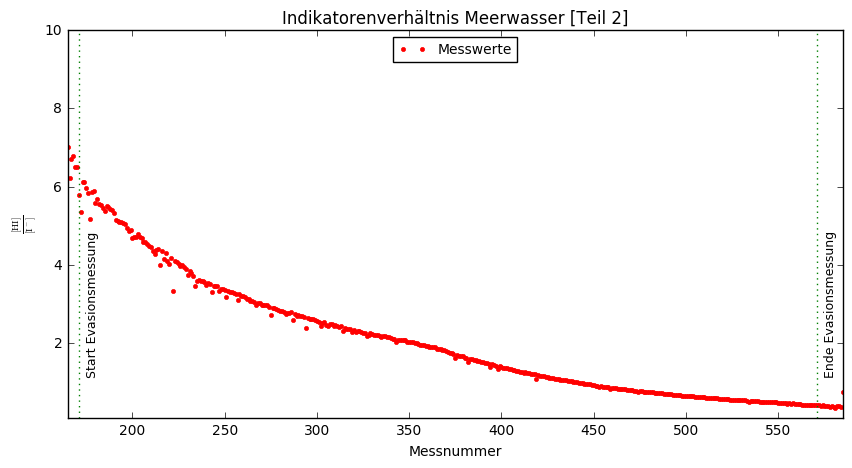

In [60]:
plt.figure(figsize=(10,5))
plt.plot(num, HI_I, 'r.', label='Messwerte')
#plt.plot(num[indices], HI_I_masked, 'k.')
plt.xlim(165, 585)
plt.ylim(0.1, 10)

plt.ylabel('$\\frac{[\\mathrm{HI}]}{[\\mathrm{I^-}]}$')
plt.xlabel('Messnummer')
plt.title('Indikatorenverhältnis Meerwasser [Teil 2]')
plt.legend(loc=9, fontsize=10)

# co2 lines, exp. start
yHeight = 3
plt.axvline(x=171, ls='dotted', color='g')  # start exp.
plt.text(175, yHeight, 'Start Evasionsmessung', rotation=90, fontsize=9, va='center')
# exp. end
plt.axvline(x=571, ls='dotted', color='g') 
plt.text(575, yHeight, 'Ende Evasionsmessung', rotation=90, fontsize=9, va='center')
#plt.savefig('Indikatorverhaeltnis_meerwasser.pdf', dpi=200)

In [61]:
# da co2 in Luft offset hat:
cA = co2-co2_off  # [cA] = ppm

# begasung: 75-149
N = len(tempWater[75:149])
# für stoffmenge
p2 = unc.ufloat(1.976, 0.013)*1e5  # [Pa]
V2 = 599.41e-6  # [m^3]
Tw2 = unc.ufloat(21.145, 0.006) + 273.15  # [K]
n = p2*V2/(8.314*Tw2)

# waterheight
hW_eff2 = (unc.ufloat(np.mean(waterHeight[75:149]), np.std(waterHeight[75:149])/np.sqrt(N)) 
           + unc.ufloat(6.89, 0.04)) * 1e-3
# volume
vW2 = hW_eff2 * 157079.63*1e-6  # in [m^3]

# concentration
c2 = n/vW2 * 1e3

# Löslichkeit
alpha2 = 0.03798

# Indikatorenverhältins zu beginn der Messung:
HI_I_0_2 = HI_I[171]  # proportional zu c
cW_ind2 = c2 * HI_I / HI_I_0_2 / alpha2

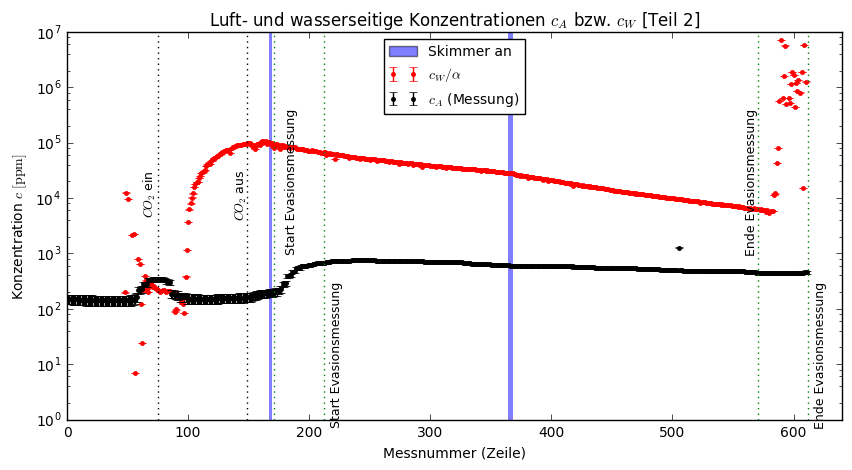

In [62]:
upper_lim = 612  # just convenience

plt.figure(figsize=(10,5))
plt.errorbar((num[1:upper_lim+1]-1), unp.nominal_values(cW_ind2)[1:upper_lim+1], 
             yerr=unp.std_devs(cW_ind2)[1:upper_lim+1], fmt='r.', 
             label='$c_W/\\alpha$')  # graph 1
plt.errorbar(num1[:upper_lim], unp.nominal_values(cA)[:upper_lim], 
             yerr=unp.std_devs(cA)[:upper_lim], fmt='k.', 
             label='$c_A$ (Messung)')  # graph 2
plt.yscale('log')

plt.title('Luft- und wasserseitige Konzentrationen $c_A$ bzw. $c_W$ [Teil 2]')

# co2 lines, exp. start
yHeight = 15
plt.axvline(x=212, ls='dotted', color='g')  # start exp.
plt.text(217, yHeight, 'Start Evasionsmessung', rotation=90, fontsize=9, va='center')
# exp. end
plt.axvline(x=612, ls='dotted', color='g') 
plt.text(617, yHeight, 'Ende Evasionsmessung', rotation=90, fontsize=9, va='center')
plt.xlabel('Messnummer (Zeile)')
plt.ylabel('Konzentration $c\ [\\mathrm{ppm}]$')
plt.xlim(0,640)


#span parameters for skimmer
ec = 'none'
fc = 'b'
op = 0.5
    
# skimmer spans
plt.axvspan(364, 368, edgecolor=ec, facecolor=fc, alpha=op, label='Skimmer an')  # skimmer
plt.axvspan(167, 169, edgecolor=ec, facecolor=fc, alpha=op)  # skimmer

# co2 lines, exp. start
yHeight = 2e4
plt.axvline(x=75, ls='dotted', color='k')  # CO2 on
plt.text(62, yHeight, '$CO_2$ ein', rotation=90, fontsize=9)
plt.axvline(x=149, ls='dotted', color='k')  # CO2 off
plt.text(137, yHeight, '$CO_2$ aus', rotation=90, fontsize=9)
plt.axvline(x=171, ls='dotted', color='g')  # start exp.
plt.text(180, yHeight, 'Start Evasionsmessung', rotation=90, fontsize=9, va='center')

# exp. end
plt.axvline(x=571, ls='dotted', color='g') 
plt.text(560, yHeight, 'Ende Evasionsmessung', rotation=90, fontsize=9, va='center')
plt.legend(loc=9, fontsize=10)
#plt.savefig('luft_wasser_konzentrationen_teil2.pdf', dpi=200)

Fit 1 [  6.10882655e-05   2.30977126e+05] [  6.64598065e-07   4.03203580e+03]
<hW>: 82.2058549223 0.75828099819 
<vW>: 6.3125388601 0.0617556592003 
<tempWater>: 21.2632124352 0.0482227286164
Fit 2 [  7.90295948e-05   4.52166425e+05] [  4.47983089e-07   8.56335161e+03]
<hW>: 79.0696212121 0.912354102328 
<vW>: 6.38 0.0282574742057 
<tempWater>: 21.3628787879 0.0483129053439
<k> (7.01+/-0.04)e-05


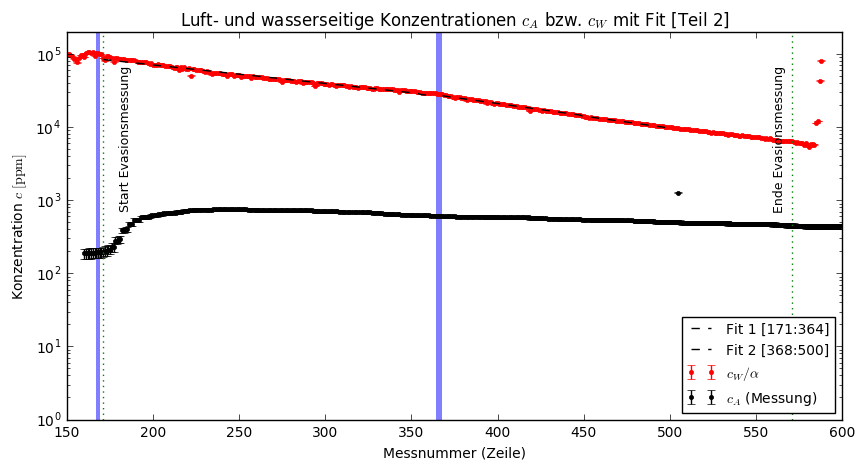

In [70]:
# fit bereiche: [171:364], [368:500]
def exp(t, k, A):
    return A*np.exp(-k/unp.nominal_values(hW) * t)

pars = []
par_errs = []

lower = [171, 368]
upper = [364, 500]

plt.figure(figsize=(10,5))
plt.errorbar(num, unp.nominal_values(cW_ind2), yerr=unp.std_devs(cW_ind2), fmt='r.', label='$c_W/\\alpha$')
plt.errorbar(num[160:600], unp.nominal_values(cA)[160:600], 
             yerr=unp.std_devs(cA)[160:600], 
             fmt='k.', label='$c_A$ (Messung)')  # graph 2

for enum,(l,u) in enumerate(zip(lower,upper)):
    enum +=1
    popt, pcov = curve_fit(exp, time[l:u], unp.nominal_values(cW_ind2[l:u]) ,sigma=unp.std_devs(cW_ind2[l:u]),
                          p0=[1e-4, unp.nominal_values(c2/alpha2)])
    popt_err = np.sqrt(np.diag(pcov))
    print('Fit '+str(enum), popt, popt_err)
    plt.plot(num[l:u], exp(time[l:u], *popt), 'k--', label='Fit ' + str(enum) + ' [' + str(l) + ':'+ str(u) + ']')
    
    pars.append(popt)
    par_errs.append(popt_err)
    
    print("<hW>:", np.mean(waterHeight[l:u]), np.std(waterHeight[l:u]), 
          "\n<vW>:", np.mean(wind[l:u]), np.std(wind[l:u]),
          "\n<tempWater>:", np.mean(tempWater[l:u]), np.std(tempWater[l:u]))
    
#plt.plot(num[l:u], exp(time[l:u], *popt), 'k--', label='Fit')
plt.xlim(150, 600)
plt.ylim(1,2e5 )
plt.yscale('log')
plt.legend(loc=0, fontsize=10)
pars = np.array(pars)
par_errs = np.array(par_errs)

plt.title('Luft- und wasserseitige Konzentrationen $c_A$ bzw. $c_W$ mit Fit [Teil 2]')
plt.xlabel('Messnummer (Zeile)')
plt.ylabel('Konzentration $c\ [\\mathrm{ppm}]$')

#span parameters for skimmer
ec = 'none'
fc = 'b'
op = 0.5
    
# skimmer spans
plt.axvspan(364, 368, edgecolor=ec, facecolor=fc, alpha=op, label='Skimmer an')  # skimmer
plt.axvspan(167, 169, edgecolor=ec, facecolor=fc, alpha=op)  # skimmer

# co2 lines, exp. start
yHeight = 7e3
plt.axvline(x=171, ls='dotted', color='g')  # start exp.
plt.text(180, yHeight, 'Start Evasionsmessung', rotation=90, fontsize=9, va='center')

# exp. end
plt.axvline(x=571, ls='dotted', color='g') 
plt.text(560, yHeight, 'Ende Evasionsmessung', rotation=90, fontsize=9, va='center')
#plt.savefig('luft_wasser_konzentrationen_teil2_fitted.pdf', dpi=200)


print('<k>', np.sum(unp.uarray(pars[:,0], par_errs[:,0]))/len(pars[:,0]))

In [71]:
print('Transfergeschwindigkeit k:','\nexp-fit:', np.mean(pars[:,0]),'[m\s] = ', np.mean(pars[:,0])*3.6e5, 
      '[cm/h]\n')

Transfergeschwindigkeit k: 
exp-fit: 7.00589301775e-05 [m\s] =  25.2212148639 [cm/h]



In [74]:
c2/alpha2

88098.57918511952+/-581.5810496309186

In [ ]:
cW_ind2[151]

In [ ]:
c/alpha